In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from linearmodels import PanelOLS
from datetime import datetime
from datetime import timedelta  


sns.set_style("darkgrid")

df = pd.read_csv('https://raw.githubusercontent.com/jugalm/News_Stocks/master/data/weekly_gti_stock_price.csv')

df = df[df.adjusted_gt_index_lag4.notnull()]
df = df[df.excess_percent_change.notnull()]
#df.m_date = pd.to_datetime(df.m_date).dt.date
X_list1 = ['adjusted_gt_index_lag1',  'adjusted_gt_index_lag2', 
                      'adjusted_gt_index_lag3', 'adjusted_gt_index_lag4',
                      'standarized_weekly_volume_lag1', 'standarized_weekly_volume_lag2',
                      'standarized_weekly_volume_lag3', 'standarized_weekly_volume_lag4',
                      'excess_percent_change_lag1', 'excess_percent_change_lag2', 
                      'excess_percent_change_lag3']
del df['Unnamed: 0']

In [2]:
X=sm.add_constant(df[X_list1])
#.join(pd.get_dummies(df.stock_symbol))

y=df.postive_excess_change_dummy

logit_model=sm.Logit(y,X)
result=logit_model.fit(maxiter=100)
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.691972
         Iterations 4
                                Results: Logit
Model:                Logit                       Pseudo R-squared: 0.002     
Dependent Variable:   postive_excess_change_dummy AIC:              10694.2051
Date:                 2019-04-12 10:46            BIC:              10777.6084
No. Observations:     7710                        Log-Likelihood:   -5335.1   
Df Model:             11                          LL-Null:          -5343.9   
Df Residuals:         7698                        LLR p-value:      0.089105  
Converged:            1.0000                      Scale:            1.0000    
No. Iterations:       4.0000                                                  
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------

In [3]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                                    2.5%     97.5%        OR
const                           0.972380  1.063999  1.017158
adjusted_gt_index_lag1          0.790744  0.969390  0.875522
adjusted_gt_index_lag2          0.931608  1.161419  1.040186
adjusted_gt_index_lag3          0.957230  1.191552  1.067983
adjusted_gt_index_lag4          0.963498  1.154362  1.054621
standarized_weekly_volume_lag1  0.919796  1.060743  0.987759
standarized_weekly_volume_lag2  0.938987  1.116013  1.023680
standarized_weekly_volume_lag3  0.936330  1.114328  1.021459
standarized_weekly_volume_lag4  0.909304  1.068622  0.985750
excess_percent_change_lag1      0.953048  0.993779  0.973200
excess_percent_change_lag2      0.972260  1.013751  0.992789
excess_percent_change_lag3      0.985244  1.027191  1.005999


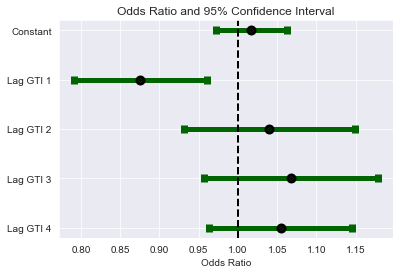

In [4]:
plt.errorbar(np.flip(np.exp(conf['OR'])[:5],0), np.flip(X.columns.tolist()[:5],0), xerr=np.flip(np.exp(conf['OR'])[:5] - np.exp(conf['2.5%'])[:5],0), 
             fmt='o', color='black', ecolor='darkgreen', elinewidth=5, capsize=4, ms=3, mew= 7);

plt.axvline(1, color='k', linestyle='dashed', linewidth=2)
sns.set_style("darkgrid")

plt.xlabel('Odds Ratio')
plt.title('Odds Ratio and 95% Confidence Interval')
plt.yticks(np.flip(X.columns.tolist()[:5],0), ('Lag GTI 4', 'Lag GTI 3', 'Lag GTI 2', 'Lag GTI 1', 'Constant'))

plt.savefig('odds_ratio.pdf')


In [5]:
import linearmodels as lm 
mod = lm.OLS(df.excess_percent_change, X)
res = mod.fit()
print(res.summary)

                              OLS Estimation Summary                             
Dep. Variable:     excess_percent_change   R-squared:                      0.0052
Estimator:                           OLS   Adj. R-squared:                 0.0038
No. Observations:                   7710   F-statistic:                    25.053
Date:                   Fri, Apr 12 2019   P-value (F-stat)                0.0090
Time:                           10:46:55   Distribution:                 chi2(11)
Cov. Estimator:                   robust                                         
                                                                                 
                                       Parameter Estimates                                        
                                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------
const                             -0.0265     0

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, y_train = df[df.m_date < '2017/1/1'][X_list1], df[df.m_date < '2017/1/1'].postive_excess_change_dummy

X_test, y_test = df[df.m_date > '2017/1/1'][X_list1], df[df.m_date > '2017/1/1'].postive_excess_change_dummy

In [7]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

        0.0       0.51      0.37      0.43       561
        1.0       0.52      0.66      0.58       579

avg / total       0.52      0.52      0.51      1140

[[206 355]
 [196 383]]


In [8]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 10))
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

        0.0       0.50      0.46      0.48       561
        1.0       0.52      0.56      0.54       579

avg / total       0.51      0.51      0.51      1140

[[257 304]
 [255 324]]


In [9]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2)
clf.fit(X_train, y_train) 

y_fit = clf.predict(X_test)
print(classification_report(y_test, y_fit))
print(confusion_matrix(y_test, y_fit))

             precision    recall  f1-score   support

        0.0       0.33      0.02      0.03       561
        1.0       0.50      0.97      0.66       579

avg / total       0.42      0.50      0.35      1140

[[  9 552]
 [ 18 561]]


In [10]:
from collections import defaultdict

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

In [11]:
def add_days(date_string, num_days):
    date_temp = (datetime.strptime(date_string, '%Y/%m/%d') + timedelta(days=num_days))
    return date_temp.strftime("%Y/%m/%d")

In [19]:
def run_simulation(data, x_list, y_var, start_week, method):
    result = []
    date_list = data.m_date.unique()
    n = len(date_list)
    for i in range(start_week, n-1):
        
        X_train = data[(data.m_date < date_list[i]) & (data.m_date >= date_list[i-52]) ][x_list]
        y_train = data[(data.m_date < date_list[i]) & (data.m_date >= date_list[i-52]) ][y_var]
        
        X_test = data[(data.m_date >= date_list[i]) & (data.m_date < date_list[i+1])][x_list]
        y_test = data[(data.m_date >= date_list[i]) & (data.m_date < date_list[i+1])][y_var]
        
        if method == 'SVM':
            clf = svm.SVC()
        elif method == 'Neural Network':
            clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2)) 
        elif method == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=2)
        elif method == 'NB':   
            clf = GaussianNB()
        
        clf.fit(X_train, y_train)
        
        y_fit = clf.predict(X_test)
        res = pd.DataFrame(report2dict(classification_report(y_test, y_fit)))
        result.append(res.loc['precision', 'avg / total'])
    return result

# SVM

In [20]:
res = run_simulation(df, X_list1, 'postive_excess_change_dummy', 52,'SVM')

print("Average accuracy of prediction: " + str(np.array(res).mean()))


Average accuracy of prediction: 0.5437745098039216


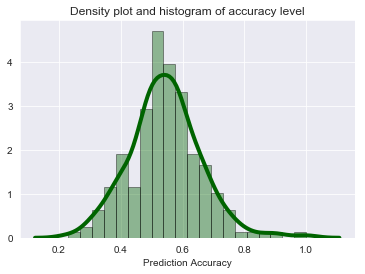

In [21]:
sns.distplot(res, hist=True, kde=True, 
             bins=int(100/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Prediction Accuracy'
plt.title('Density plot and histogram of accuracy level')
plt.savefig('svm.pdf')


Average accuracy of prediction: 0.5318627450980392


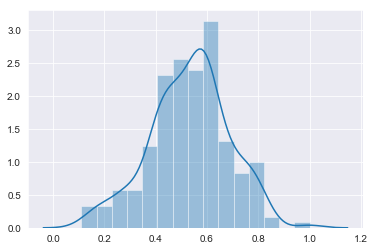

In [22]:
res = run_simulation(df, X_list1, 'postive_excess_change_dummy', 52,'Neural Network')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)

Average accuracy of prediction: 0.524656862745098


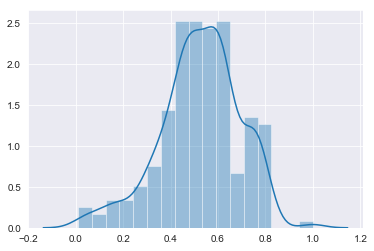

In [23]:
res = run_simulation(df, X_list1, 'postive_excess_change_dummy', 52,'Neural Network')

print("Average accuracy of prediction: " + str(np.array(res).mean()))

sns.distplot(res)